# Power and FPR Simulation

Power, FPR, and null analysis for differential expression via a series of simulation studies. 

### Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp

In [4]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc')
import simplesc

### Simulation function


In [23]:
def simulate_data(mean, cov, p, num_cells, group_name, num_genes=2):
    
    norm_continuous = stats.multivariate_normal.rvs(mean=mean, cov=cov, size=num_cells)
    continuous = np.exp(norm_continuous)
    ground_truth_counts = np.round(continuous).astype(np.int64)
    observed = np.random.binomial(n=ground_truth_counts, p=p)
    
    adata = sc.AnnData(observed)
    #adata = sc.AnnData(sp.sparse.csr_matrix(observed))
    adata.obs['group'] = group_name
    adata.var.index = ['gene_1', 'gene_2']
    adata.obs.index = ['cell_' + str(i) for i in range(num_cells)]
    
    return adata

### Model fitting function

In [191]:
def fit_model(adata, p, group_1='g1', group_2='g2', num_permute=5):
    
    estimator = simplesc.SingleCellEstimator(
        adata, 
        p=p, 
        num_permute=num_permute,
        group_label='group')
    
    estimator.compute_observed_statistics(group=group_1)
    #estimator.compute_observed_statistics(group=group_2)
        
    estimator.compute_params(group=group_1)
    #estimator.compute_params(group=group_2)

    estimator.compute_permuted_statistics(group=group_1)
    #estimator.compute_permuted_statistics(group=group_2)
    
    return estimator

### Differential Expression

Assumes identical covariance matrices between the two groups.

In [19]:
# Parameters for FPR simulation
num_trials = 100
num_cells = 1000
p = 0.1
p_hat = 0.1

mu_1 = np.array([1, 2])
cov_1 = np.array([[1.5, 1], [1, 2]])

In [20]:
adata_fpr = \
    simulate_data(mu_1, cov_1, p, num_cells, 'g1')

estimator = fit_model(adata_fpr, num_permute=100)

ValueError: input must be a square array

In [16]:
estimator.estimated_mean

{'g1': array([0.97736369, 2.108691  ]), 'g2': array([1.05508784, 2.12243377])}

In [ ]:
estimator.estimated_mean

In [26]:
imp.reload(simplesc)

<module 'simplesc' from '/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py'>

In [27]:
g1_pvals = []
g2_pvals = []

for diff in [0.1, 0.25, 0.5, 0.75, 1, 1.2]:
    
    g1_pval = np.zeros(num_trials) # different mean
    g2_pval = np.zeros(num_trials) # same mean
    
    mu_2[0] = mu_1[0] + diff
    for trial in range(num_trials):

        adata_fpr = \
            simulate_data(mu_1, cov_1, p, num_cells, 'g1')\
            .concatenate(
                simulate_data(mu_2, cov_2, p, num_cells, 'g2'))

        estimator = fit_model(adata_fpr, num_permute=100)

        t_stat, null_t, pvals = estimator.differential_expression('g1', 'g2')

        g1_pval[trial] = pvals[0]
        g2_pval[trial] = pvals[1]
    
    g1_pvals.append(g1_pval)
    g2_pvals.append(g2_pval)



In [28]:
power = [(pval < 0.05).mean() for pval in g1_pvals]
fpr = [(pval < 0.05).mean() for pval in g2_pvals]

(0, 1)

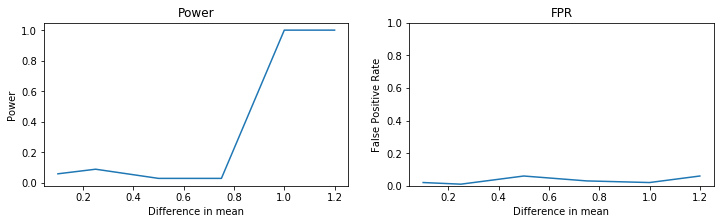

In [35]:
plt.figure(figsize=(12, 3));
plt.subplot(1, 2, 1);
plt.plot([0.1, 0.25, 0.5, 0.75, 1, 1.2], power);
plt.title('Power'); plt.xlabel('Difference in mean'); plt.ylabel('Power');
plt.subplot(1, 2, 2);
plt.plot([0.1, 0.25, 0.5, 0.75, 1, 1.2], fpr);
plt.title('FPR'); plt.xlabel('Difference in mean'); plt.ylabel('False Positive Rate'); plt.ylim(0, 1)

### Differential variance

In [36]:
# Parameters for FPR simulation
num_trials = 100
num_cells = 1000
p = 0.1
p_hat = 0.1

mu_1 = np.array([1.0, 1.5])
cov_1 = np.array([[1, 0], [0, 2]])

mu_2 = mu_1.copy()
cov_2 = cov_1.copy()

In [37]:
imp.reload(simplesc)

<module 'simplesc' from '/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc/simplesc.py'>

In [38]:
g1_pvals = []
g2_pvals = []

for diff in [0.1, 0.25, 0.5, 0.75, 1, 1.2]:
    
    g1_pval = np.zeros(num_trials) # different mean
    g2_pval = np.zeros(num_trials) # same mean
    
    cov_2[0][0] = cov_1[0][0] + diff
    for trial in range(num_trials):

        adata_fpr = \
            simulate_data(mu_1, cov_1, p, num_cells, 'g1')\
            .concatenate(
                simulate_data(mu_2, cov_2, p, num_cells, 'g2'))

        estimator = fit_model(adata_fpr, num_permute=100)

        t_stat, null_t, pvals = estimator.differential_variance('g1', 'g2')

        g1_pval[trial] = pvals[0]
        g2_pval[trial] = pvals[1]
    
    g1_pvals.append(g1_pval)
    g2_pvals.append(g2_pval)



In [39]:
power = [(pval < 0.05).mean() for pval in g1_pvals]
fpr = [(pval < 0.05).mean() for pval in g2_pvals]

(0, 1)

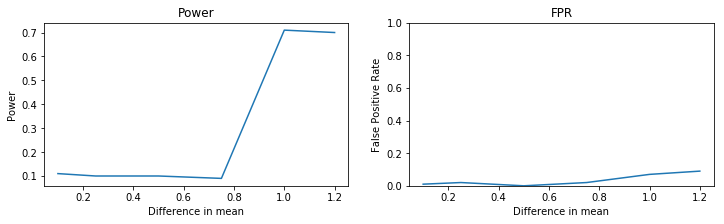

In [41]:
plt.figure(figsize=(12, 3));
plt.subplot(1, 2, 1);
plt.plot([0.1, 0.25, 0.5, 0.75, 1, 1.2], power);
plt.title('Power'); plt.xlabel('Difference in mean'); plt.ylabel('Power');
plt.subplot(1, 2, 2);
plt.plot([0.1, 0.25, 0.5, 0.75, 1, 1.2], fpr);
plt.title('FPR'); plt.xlabel('Difference in mean'); plt.ylabel('False Positive Rate'); plt.ylim(0, 1)